In [1]:
library(naturalsort)
library(fields)
library(viridis)
load('~/jackgl/sim-develop/data/genomes/hg38/exonicvsnon_counts.rda')

dataDir <- '~/jackgl/Data/simulations/1118/lusc_1115_1/'
ctype <- 'LUSC'

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Loading required package: viridisLite
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
flst <- naturalsort(list.files(dataDir))
flst <- flst[3:(length(flst))]

In [3]:
Ns <- array(NA,dim=c(length(flst),5e3))
nd_het <- rep(NA,length(flst))
nd_hom <- rep(NA,length(flst))
np_het <- rep(NA,length(flst))
np_hom <- rep(NA,length(flst))
mus <- rep(NA,length(flst))
N0s <- rep(NA,length(flst))
sds <- rep(NA,length(flst))
sps <- rep(NA,length(flst))

for (ii in 1:length(flst)) {
    load(paste0(dataDir,flst[ii]))
    N[N==0] <- NA
    Ns[ii,] <- N
    nd_het[ii] <- sum(Pop$nd_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    nd_hom[ii] <- sum(Pop$nd_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_het[ii] <- sum(Pop$np_het[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    np_hom[ii] <- sum(Pop$np_hom[Pop$ncells!=0]*Pop$ncells[Pop$ncells!=0]/sum(Pop$ncells))
    mus[ii] <- mu
    N0s[ii] <- N0
    sds[ii] <- sd
    sps[ii] <- sp
    rm(Pop,gen_time,N,mut_genes,N0,mu,sd,sp)
}

In [4]:
get_fc <- function(N) {
    return(N[length(which(!is.na(N)))]/N[1])
}

In [5]:
unique(mus)

[1] 0.001231465 0.002462929 0.012314646 0.024629293 0.123146464

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  3.767837e-05 (eff. df= 46.55 )


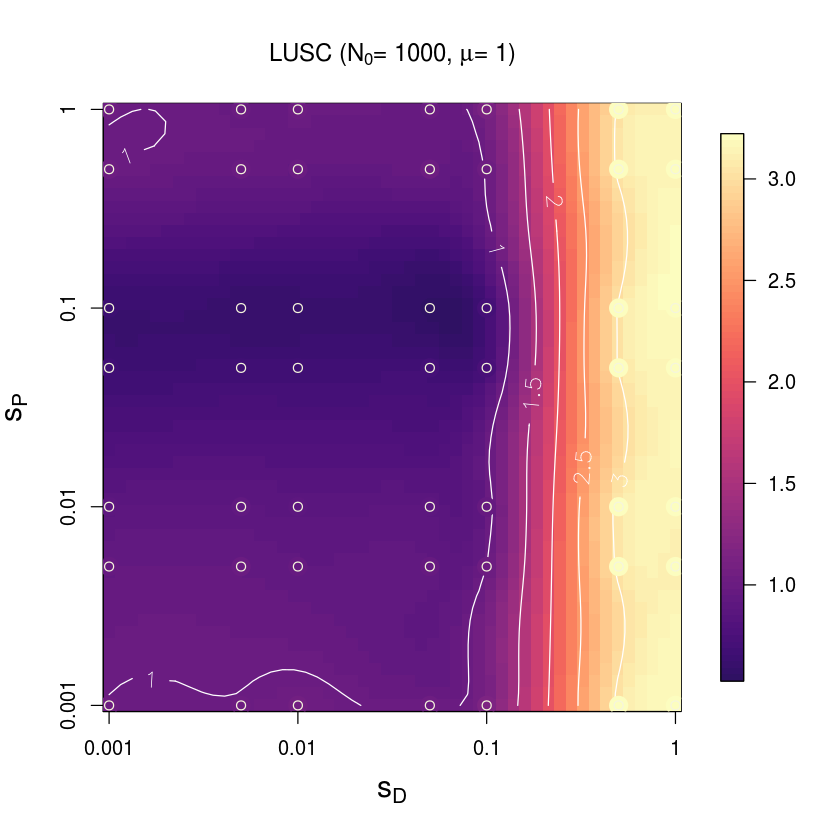

In [6]:
# Assign data to temporary objects
idx <- which(N0s==1000 & mus==unique(mus)[4])

x <- log(sds[idx])
y <- log(sps[idx])
z <- as.vector(apply(Ns,1,get_fc))[idx]
# z <- np_het[idx]

options(repr.plot.width=7, repr.plot.height=7)
quant <- function(x) {quantile(x,.5)}
closest <- function(x,v) {
    return(which.min(abs(v - x)))
}

cor <- data.frame(x=x,y=y,z=z)
test <- aggregate(cor, by=list(x,y), FUN=quant)
test$x <- test$Group.1
test$y <- test$Group.2
# test <- test[test$y>=50,]

# Thin plate spline interpolation to irregular data
test.spline <- Tps(data.frame(test$x,test$y), test$z)#, lambda=0.001)

new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
v=quantile(seq(0,3,0.01),seq(0.01,1,.01),na.rm=TRUE)
# v=quantile(seq(0,200,0.01),seq(0.01,1,.01),na.rm=TRUE)

cols <- magma(100)
image.plot(new.grid,
          col=cols[closest(min(new.grid$z[!is.na(new.grid$z)]),v):closest(max(new.grid$z[!is.na(new.grid$z)]),v)],
          xlab=expression(s[D]),
          ylab=expression(s[P]),
          cex.lab=1.5,
          main=bquote(paste(.(ctype),' (',N[0],'= 1000, ',mu,'= 1)')),
          xaxt='n',
          yaxt='n')

contour(new.grid,add=TRUE,nlevels=5,col='white',labcex=1.2)
axis(2,at=c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0)),label=round(exp(c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0))),4))
axis(1,at=c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0)),label=round(exp(c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0))),4))

points(test$x,test$y,
       col=cols[as.numeric(lapply(test$z,closest,v))],
       pch=20,
       cex=3)
points(test$x,test$y,pch=1,col='beige')

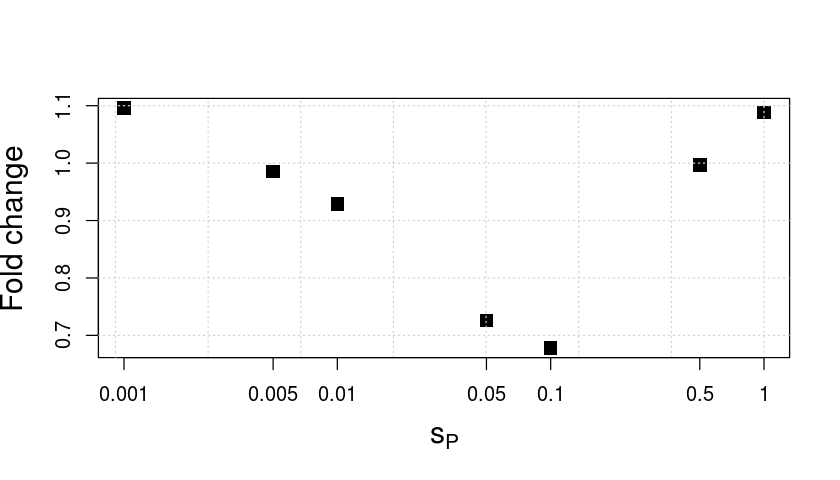

In [7]:
options(repr.plot.width=7, repr.plot.height=4)
plot(test$y[test$x==log(0.1)],test$z[test$x==log(0.1)],
     type='p',
     col='black',
     pch=15,
     cex=1.5,
     xlab=expression(s[P]),
     cex.lab=1.5,
     ylab='Fold change',
     xaxt='n')
grid()
axis(1,at=c(log(.001),log(.005),log(.01),log(.05),log(.1),log(.5),log(1)),
     label=round(exp(c(log(.001),log(.005),log(.01),log(.05),log(.1),log(.5),log(1))),4))

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  6.054843e-05 (eff. df= 26.59999 )


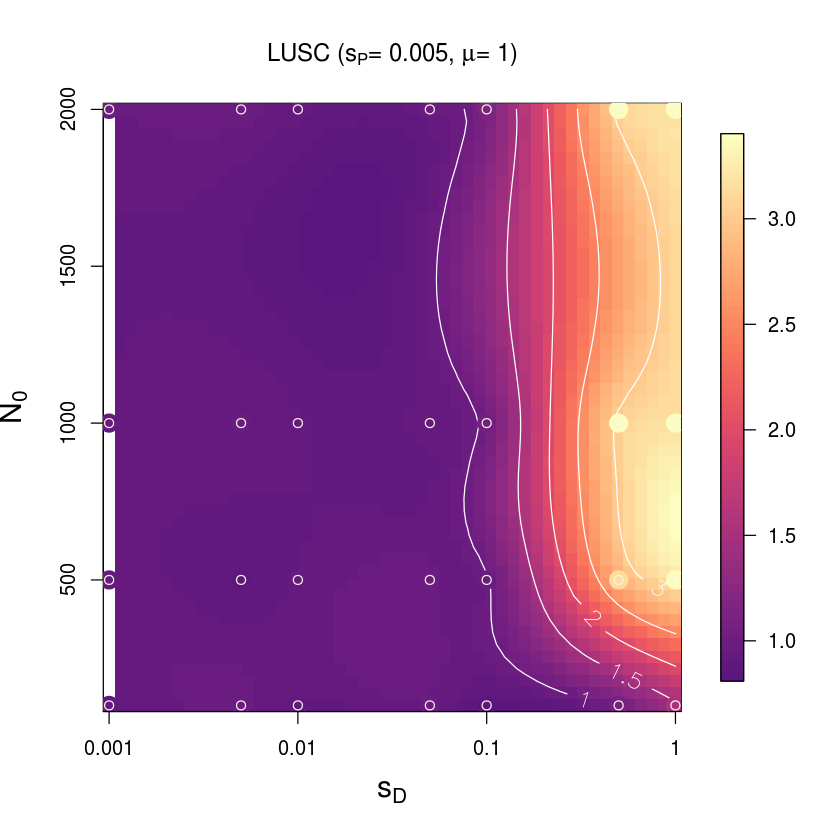

In [8]:
# Assign data to temporary objects
# idx <- which(N0s==1000 & mus==unique(mus)[4])
# idx <- which(N0s==1000 & sps==0.05)
idx <- which(mus==unique(mus)[4] & sps==0.005)

x <- log(sds[idx])
# y <- log(sps[idx])
# y <- mus[idx]
y <- N0s[idx]
z <- as.vector(apply(Ns,1,get_fc))[idx]
# z <- np_het[idx]

options(repr.plot.width=7, repr.plot.height=7)
quant <- function(x) {quantile(x,.5)}
closest <- function(x,v) {
    return(which.min(abs(v - x)))
}

cor <- data.frame(x=x,y=y,z=z)
test <- aggregate(cor, by=list(x,y), FUN=mean)
test$x <- test$Group.1
test$y <- test$Group.2
# test <- test[test$y>=50,]

# Thin plate spline interpolation to irregular data
test.spline <- Tps(data.frame(test$x,test$y), test$z)#, lambda=0.001)

new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
v=quantile(seq(0,3,0.01),seq(0.01,1,.01),na.rm=TRUE)
# v=quantile(seq(0,200,0.01),seq(0.01,1,.01),na.rm=TRUE)

cols <- magma(100)
image.plot(new.grid,
          col=cols[closest(min(new.grid$z[!is.na(new.grid$z)]),v):closest(max(new.grid$z[!is.na(new.grid$z)]),v)],
          xlab=expression(s[D]),
          ylab=expression(N[0]),
          cex.lab=1.5,
          main=bquote(paste(.(ctype),' (',s[P],'= 0.005, ',mu,'= 1)')),
          xaxt='n')
#           yaxt='n')

contour(new.grid,add=TRUE,nlevels=5,col='white',labcex=1.2)
# axis(2,at=c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0)),label=round(exp(c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0))),4))
axis(1,at=c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0)),label=round(exp(c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0))),4))

points(test$x,test$y,
       col=cols[as.numeric(lapply(test$z,closest,v))],
       pch=20,
       cex=3)
points(test$x,test$y,pch=1,col='beige')

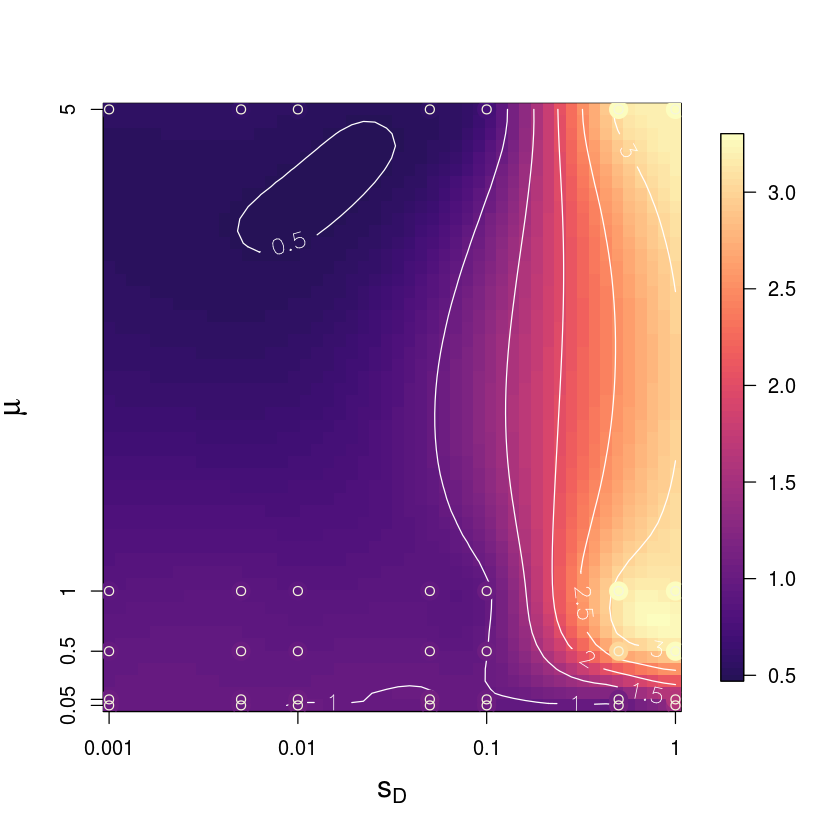

In [9]:
# Assign data to temporary objects
# idx <- which(N0s==1000 & mus==unique(mus)[4])
idx <- which(N0s==1000 & sps==0.01)

x <- log(sds[idx])
# y <- log(sps[idx])
y <- mus[idx]
z <- as.vector(apply(Ns,1,get_fc))[idx]
# z <- np_het[idx]

options(repr.plot.width=7, repr.plot.height=7)
quant <- function(x) {quantile(x,.5)}
closest <- function(x,v) {
    return(which.min(abs(v - x)))
}

cor <- data.frame(x=x,y=y,z=z)
test <- aggregate(cor, by=list(x,y), FUN=mean)
test$x <- test$Group.1
test$y <- test$Group.2
# test <- test[test$y>=50,]

# Thin plate spline interpolation to irregular data
test.spline <- Tps(data.frame(test$x,test$y), test$z)#, lambda=0.001)

new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
v=quantile(seq(0,3,0.01),seq(0.01,1,.01),na.rm=TRUE)
# v=quantile(seq(0,200,0.01),seq(0.01,1,.01),na.rm=TRUE)

cols <- magma(100)
image.plot(new.grid,
          col=cols[closest(min(new.grid$z[!is.na(new.grid$z)]),v):closest(max(new.grid$z[!is.na(new.grid$z)]),v)],
          xlab=expression(s[D]),
          ylab=expression(mu),
          cex.lab=1.5,
#           main=bquote(paste(.(ctype),' (',N[0],'= 1000, ',mu,'= 1)')),
          xaxt='n',
          yaxt='n')
contour(new.grid,add=TRUE,nlevels=5,col='white',labcex=1.2)
axis(2,at=unique(mus),label=c(0.05,0.1,0.5,1,5))
axis(1,at=c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0)),label=round(exp(c(log(1e-4),log(1e-3),log(1e-2),log(1e-1),log(1e0))),4))

points(test$x,test$y,
       col=cols[as.numeric(lapply(test$z,closest,v))],
       pch=20,
       cex=3)
points(test$x,test$y,pch=1,col='beige')

In [1]:
# Assign data to temporary objects
idx <- which(sds==0.5 & sps==0.1)
x <- mus[idx]
y <- N0s[idx]
# z <- as.vector(apply(Ns,1,get_fc))[idx]
z <- np_het[idx]

options(repr.plot.width=7, repr.plot.height=7)
quant <- function(x) {quantile(x,.5)}
closest <- function(x,v) {
    return(which.min(abs(v - x)))
}

cor <- data.frame(x=x,y=y,z=z)
test <- aggregate(cor, by=list(x,y), FUN=quant)
test$x <- test$Group.1
test$y <- test$Group.2
# test <- test[test$y>=50,]

# Thin plate spline interpolation to irregular data
test.spline <- Tps(data.frame(test$x,test$y), test$z)

new.grid <- predictSurface(test.spline, nx = 50, ny = 50)
v=quantile(seq(0,3.2,0.01),seq(0.01,1,.01),na.rm=TRUE)
# v=quantile(seq(0,5e2,0.01),seq(0.01,1,.01),na.rm=TRUE)

cols <- magma(100)
image.plot(new.grid,
          col=cols[closest(min(new.grid$z[!is.na(new.grid$z)]),v):closest(max(new.grid$z[!is.na(new.grid$z)]),v)],
          xlab=expression(mu),
          ylab=expression(N[0]),
          cex.lab=1.5,
          xaxt='n')
#           main=bquote(paste(.(ctype),' (',s[d],'= 0.1, ',s[p],'= 0.01)')))
axis(1,at=unique(mus),label=c(0.05,0.1,0.5,1,5))

contour(new.grid,add=TRUE,nlevels=5,col='white',labcex=1.2,method='edge')

points(test$x,test$y,
       col=cols[as.numeric(lapply(test$z,closest,v))],
       pch=20,
       cex=3)
points(test$x,test$y,pch=1,col='beige')

ERROR: Error in which(sds == 0.5 & sps == 0.1): object 'sds' not found


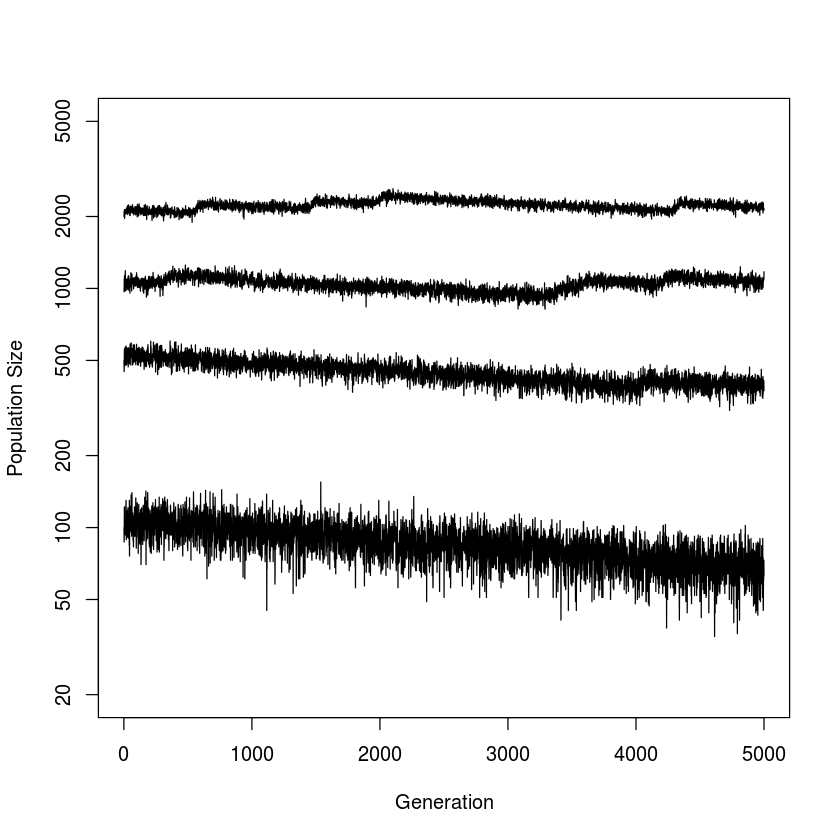

In [11]:
# Assign data to temporary objects
idx <- which(sds==0.1 & sps==0.005 & round(mus*(1/pd_exvsnon_m[1]),2)==5)
ntrial <- 5
tmp <- Ns[idx,][seq(ntrial,ntrial+15,5),]
plot(tmp[1,],type='l',
     ylim=c(2e1,5e3),
     log='y',
     xlab='Generation',
     ylab='Population Size')
for (ii in 2:4) {
    lines(tmp[ii,])
}

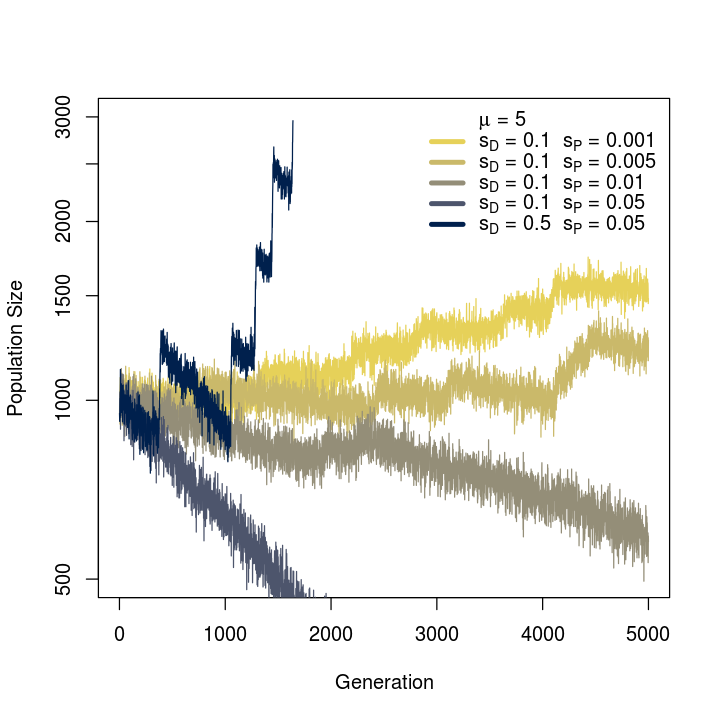

In [277]:
# Assign data to temporary objects
cols <- cividis(100)[c(1,30,60,80,90)]
# cols <- cividis(6)
idx <- which(sds==0.1 & sps==0.001 & round(mus*(1/pd_exvsnon_m[1]),2)==5 & N0s==1000)
tmp <- Ns[idx,]-50
options(repr.plot.width=6, repr.plot.height=6)
plot(tmp[5,],type='l',
     ylim=c(5e2,3e3),
     log='y',
     xlab='Generation',
     ylab='Population Size',
     col=cols[5])

idx <- which(sds==0.1 & sps==0.005 & round(mus*(1/pd_exvsnon_m[1]),2)==5 & N0s==1000)
tmp <- Ns[idx,]-50
lines(tmp[4,],
      col=cols[4])

idx <- which(sds==0.1 & sps==0.01 & round(mus*(1/pd_exvsnon_m[1]),2)==5 & N0s==1000)
tmp <- Ns[idx,]-50
lines(tmp[5,],
      col=cols[3])

idx <- which(sds==0.1 & sps==0.05 & round(mus*(1/pd_exvsnon_m[1]),2)==5 & N0s==1000)
tmp <- Ns[idx,]-50
lines(tmp[5,],
      col=cols[2])

idx <- which(sds==0.5 & sps==0.05 & round(mus*(1/pd_exvsnon_m[1]),2)==5 & N0s==1000)
tmp <- Ns[idx,]-50
lines(tmp[4,],
      col=cols[1])

legend(2800,3200,
       legend=c(expression(paste(mu,' = ',5)),
                expression(paste(s[D],' = ',0.1,'  ',s[P],' = ',0.001)),
                expression(paste(s[D],' = ',0.1,'  ',s[P],' = ',0.005)),
                expression(paste(s[D],' = ',0.1,'  ',s[P],' = ',0.01)),
                expression(paste(s[D],' = ',0.1,'  ',s[P],' = ',0.05)),
                expression(paste(s[D],' = ',0.5,'  ',s[P],' = ',0.05))),
      bty='n',
      lty=c(0,1,1,1,1,1),
      lwd=4,
      col=c(cols[1],cols[5:1]))
